In [1]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
import scipy.io 

import laplace
%matplotlib inline
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
class Network(torch.nn.Module):
    def __init__(self,layers,non_linear):
        super(Network, self).__init__()
        self.layers=layers
        self.non_linear=non_linear
        
        self.HiddenLayers = torch.nn.ModuleList()
        self.HiddenLayersNon = []
        
        for i in range(len(self.layers)-2):
            self.HiddenLayers.append(torch.nn.Linear(layers[i], layers[i+1]))
            self.HiddenLayersNon.append(self.non_linear);

        self.readout = torch.nn.Linear(self.layers[-2], self.layers[-1])

    def forward(self, x):
        for hiddenLayer, hiddenLayernon in zip(self.HiddenLayers, self.HiddenLayersNon):
            x = hiddenLayer(x)
            x = hiddenLayernon(x)
        return self.readout(x)

In [4]:
#
def diff(u,x,order=1):
    grad = torch.autograd.grad(u.sum(),x,create_graph=True)[0]
    for i in range(1,order):
        grad = torch.autograd.grad(grad.sum(),x,create_graph=True)[0]
    return grad

def running_mean(x, N=100):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [5]:
def f(x,t,net):
    input = torch.hstack([x,t])
    u = net(input)
    u_x = diff(u,x)
    u_t = diff(u,t)
    u_xx = diff(u_x,x)
    return (u_t + u*u_x - (0.01/torch.pi)*u_xx)
    #return f_pw(u,u_x,u_t,u_xx)

In [6]:
data = scipy.io.loadmat('./burgers_shock.mat')
t_ = torch.tensor(data['t'].flatten()).float()
x_ = torch.tensor(data['x'].flatten()).float()
Exact = np.real(data['usol']).T

X,T=torch.meshgrid(x_,t_,indexing='xy')
X_exact=X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_exact = Exact.flatten()[:,None]              

In [97]:
t = torch.linspace(0,1,251).float()
x = torch.linspace(-1,1,501).float()
bc_l=torch.vstack([-1*torch.ones_like(t),t]).T
bc_r=torch.vstack([torch.ones_like(t),t]).T
ic=torch.vstack([x,torch.zeros_like(x)]).T
data_grid=torch.concat([bc_l,bc_r,ic])
x=data_grid[:,0]
t=data_grid[:,1]
#X,T=torch.meshgrid(x,t,indexing='xy')
u_star=torch.as_tensor([-np.sin(i[0]*np.pi) if i[1]==0 else 0. for i in data_grid])[:,None]

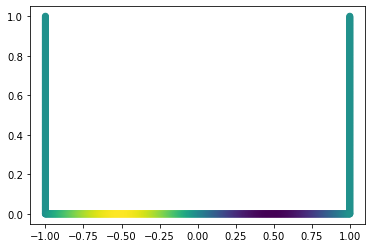

In [98]:
plt.scatter(data_grid[:,0],data_grid[:,1],c=u_star)

In [185]:
#model = Network([2, 20, 20, 20, 20, 20, 20, 20, 1],torch.nn.CELU()).to(device)
#model = Network([2,16,16,16,16,1],torch.nn.Tanh()).to(device)
model = torch.nn.Sequential(
    torch.nn.Linear(2, 8), torch.nn.Tanh(),
    torch.nn.Linear(8, 8), torch.nn.Tanh(),
    torch.nn.Linear(8, 1)).to(device)
'''
model = torch.nn.Sequential(
    torch.nn.Linear(2, 16), torch.nn.Tanh(),
    torch.nn.Linear(16, 16), torch.nn.Tanh(),
    torch.nn.Linear(16, 16), torch.nn.Tanh(),
    torch.nn.Linear(16, 16), torch.nn.Tanh(),
    torch.nn.Linear(16, 1)).to(device)
'''
#model = Network([2,20,20,20,20,1],torch.nn.Tanh()).to(device)

mse = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters())

iters=30000
#N_data=2000
N_col=1000

train_error=[]
test_error=[]
mse_fs=[]
mse_us=[]

x=x.flatten()[:,None]
t=t.flatten()[:,None]
u=u_star[:]

x_bc = torch.as_tensor(x,device=device).float()
t_bc = torch.as_tensor(t,device=device).float()
u_bc = torch.as_tensor(u,device=device).float()


###Random points
#x_col=((data_grid.min()-data_grid.max())*torch.rand(N_col,1,device=device) + data_grid.max()).clone().detach().requires_grad_(True)
shift=1.
x_col=(shift*(data_grid.min()-data_grid.max())*torch.rand(N_col,1,device=device) + shift*data_grid.max()).clone().detach().requires_grad_(True)
#t_col=((.5*torch.rand(N_col,1,device=device))).clone().detach().requires_grad_()
t_col=torch.rand(N_col,1,device=device).requires_grad_()

###Regular Grid
'''
a=torch.linspace(-1,1,int(np.sqrt(N_col))+1)
b=torch.linspace(0,1,int(np.sqrt(N_col))+1)
A,B=(torch.meshgrid(a,b,indexing='xy'))
dots=(torch.dstack([A.flatten(),B.flatten()]).squeeze())
x_col=dots[:,0].to(device).requires_grad_()[:,None]
t_col=dots[:,1].to(device).requires_grad_()[:,None]
'''

zeros = torch.zeros((x_col.shape[0],1)).to(device)

for i in range(iters):
    optimizer.zero_grad(set_to_none=True) 
    
    #mse_u
    net_bc_out=model(torch.hstack([x_bc,t_bc]))
    mse_u = mse(net_bc_out, u_bc)
    
    #x_col=(shift*(data_grid.min()-data_grid.max())*torch.rand(N_col,1,device=device) + shift*data_grid.max()).clone().detach().requires_grad_(True)
    #t_col=torch.rand(N_col,1,device=device).requires_grad_()

    #mse_f
    f_out = f(x_col, t_col, model) 
    mse_f = mse(f_out, zeros)
    loss = torch.add(mse_u ,  mse_f)
    
    loss.backward() 
    optimizer.step() 
    if ((i+1)%100==0):
        with torch.autograd.no_grad():
            train_error.append(loss.data)
            mse_us.append(mse_u.data)
            mse_fs.append(mse_f.data)
            pred=model(torch.as_tensor(X_exact,device=device))
            test_r=torch.square(torch.linalg.norm(pred-torch.as_tensor(u_exact,device=device)))/pred.shape[0]
            test_error.append(test_r)
            if ((i+1)%1000==0):
                print(i+1,"Training Loss:",loss.data,", Test loss: ",test_r.data)
            
mse_us=torch.stack(mse_us).cpu()
mse_fs=torch.stack(mse_fs).cpu()
train_error=torch.stack(train_error).cpu()
test_error=torch.stack(test_error).cpu()

1000 Training Loss: tensor(0.0860, device='cuda:0') , Test loss:  tensor(0.1256, device='cuda:0', dtype=torch.float64)
2000 Training Loss: tensor(0.0673, device='cuda:0') , Test loss:  tensor(0.1014, device='cuda:0', dtype=torch.float64)
3000 Training Loss: tensor(0.0577, device='cuda:0') , Test loss:  tensor(0.0918, device='cuda:0', dtype=torch.float64)
4000 Training Loss: tensor(0.0520, device='cuda:0') , Test loss:  tensor(0.0827, device='cuda:0', dtype=torch.float64)
5000 Training Loss: tensor(0.0473, device='cuda:0') , Test loss:  tensor(0.0771, device='cuda:0', dtype=torch.float64)
6000 Training Loss: tensor(0.0438, device='cuda:0') , Test loss:  tensor(0.0732, device='cuda:0', dtype=torch.float64)
7000 Training Loss: tensor(0.0419, device='cuda:0') , Test loss:  tensor(0.0703, device='cuda:0', dtype=torch.float64)
8000 Training Loss: tensor(0.0353, device='cuda:0') , Test loss:  tensor(0.0580, device='cuda:0', dtype=torch.float64)
9000 Training Loss: tensor(0.0318, device='cuda:

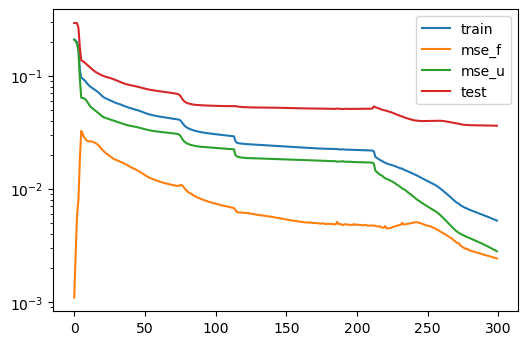

In [186]:
plt.figure(dpi=100)
plt.plot(train_error,label='train')
plt.plot(mse_fs,label='mse_f')
plt.plot(mse_us,label='mse_u')
plt.plot(test_error.cpu(),label='test')
plt.yscale('log')
plt.legend()
#plt.savefig('./figs/100kIters10kData10kCol.jpg')

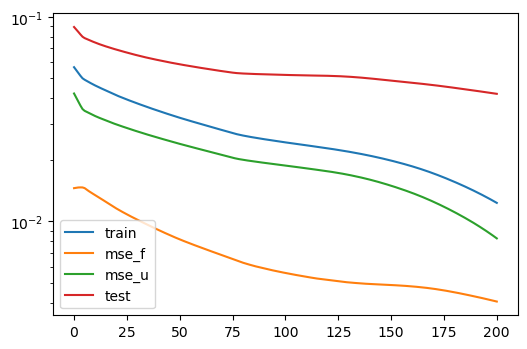

In [187]:
plt.figure(dpi=100)
plt.plot(running_mean(train_error),label='train')
plt.plot(running_mean(mse_fs),label='mse_f')
plt.plot(running_mean(mse_us),label='mse_u')
plt.plot(running_mean(test_error),label='test')
plt.yscale('log')
plt.legend()

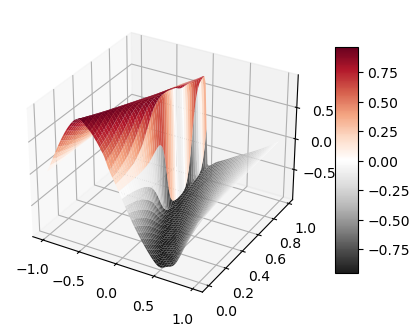

In [188]:

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(dpi=100)
ax = fig.add_subplot(projection='3d')

x1=np.arange(X_star.min(),X_star.max(),0.02)
x2=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x1, x2)
x1 = np.ravel(ms_x).reshape(-1,1)
x2 = np.ravel(ms_t).reshape(-1,1)

pt_x= torch.tensor(x1, requires_grad=True).float().to(device)
pt_t= torch.tensor(x2, requires_grad=True).float().to(device)
pt_u=model(torch.hstack([pt_x,pt_t]))
u=pt_u.detach().cpu().numpy()
ms_u = u.reshape(ms_x.shape)
pred_u=ms_u
surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.RdGy_r)
fig.colorbar(surf, shrink=.75, aspect=10)
plt.show()

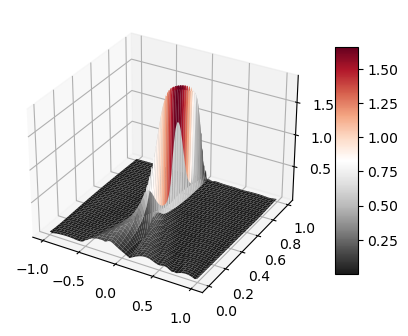

In [189]:

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(dpi=100)
ax = fig.add_subplot(projection='3d')

pt_u=model(torch.tensor(X_star).to(device))
ms_u = u_exact.reshape(X.shape)
pt_u=pt_u.reshape(X.shape)
surf = ax.plot_surface(X,T,(abs(ms_u-pt_u.detach().cpu().numpy())), cmap=cm.RdGy_r)
fig.colorbar(surf, shrink=.75, aspect=10)
plt.show()

Text(0.5, 1.0, '$t = 0.75$')

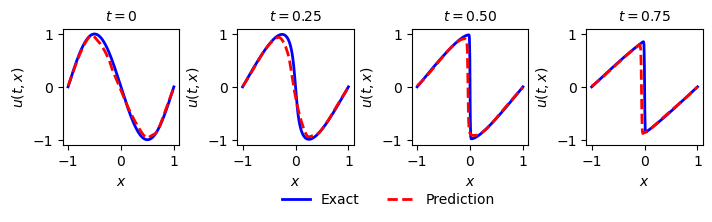

In [190]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata

def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

plt.figure(dpi=100,figsize=(8,10))
pred=model(torch.tensor(X_exact).to(device)).cpu().detach().numpy()
U_pred = griddata(X_exact, pred.flatten(), (X, T), method='cubic')


############################################################################
############################################################################
############################################################################


gs1 = gridspec.GridSpec(1, 4)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

x1 = torch.tensor(data['x'].flatten()).float()
ax = plt.subplot(gs1[0, 0])

ax.plot(x1,Exact[0,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x1,U_pred[0,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax = plt.subplot(gs1[0, 1])
ax.plot(x1,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x1,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 2])
ax.plot(x1,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x1,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)

ax.legend(loc='upper center', bbox_to_anchor=(-0.2, -0.3), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 3])
ax.plot(x1,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x1,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)

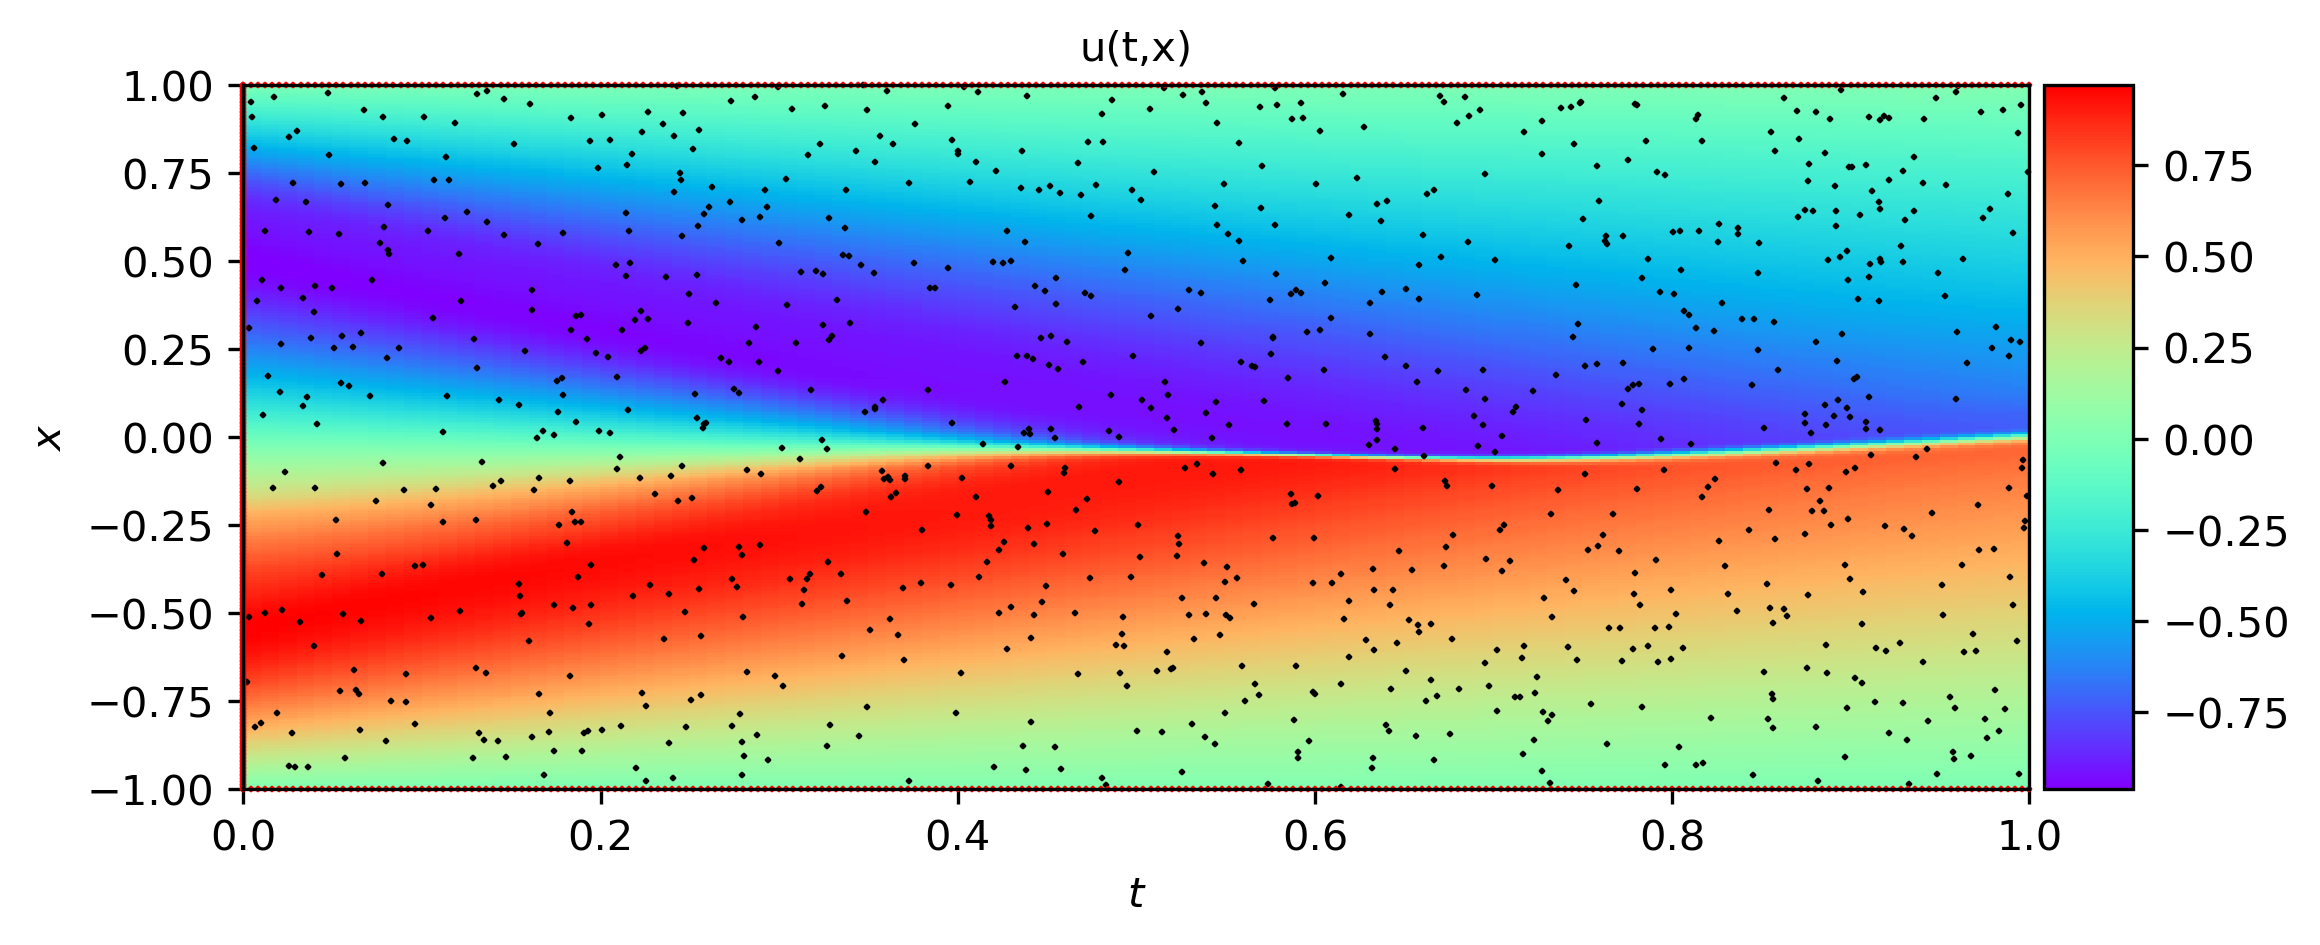

In [191]:

plt.figure(dpi=300,figsize=(9,11))
ax.axis('off')
U_pred = griddata(X_exact, pred.flatten(), (X, T), method='cubic')
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                  extent=[t.min(), t.max(), x.min(), x.max()], 
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('u(t,x)', fontsize = 10)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax.plot(t_col.detach().cpu(),x_col.detach().cpu(), 'kx', label = 'Data (%d points)' % (u_star.shape[0]), markersize = 1, clip_on = False)
ax.plot(data_grid[:,1],data_grid[:,0], 'rx', label = 'Data (%d points)' % (u_star.shape[0]), markersize = 1, clip_on = False)

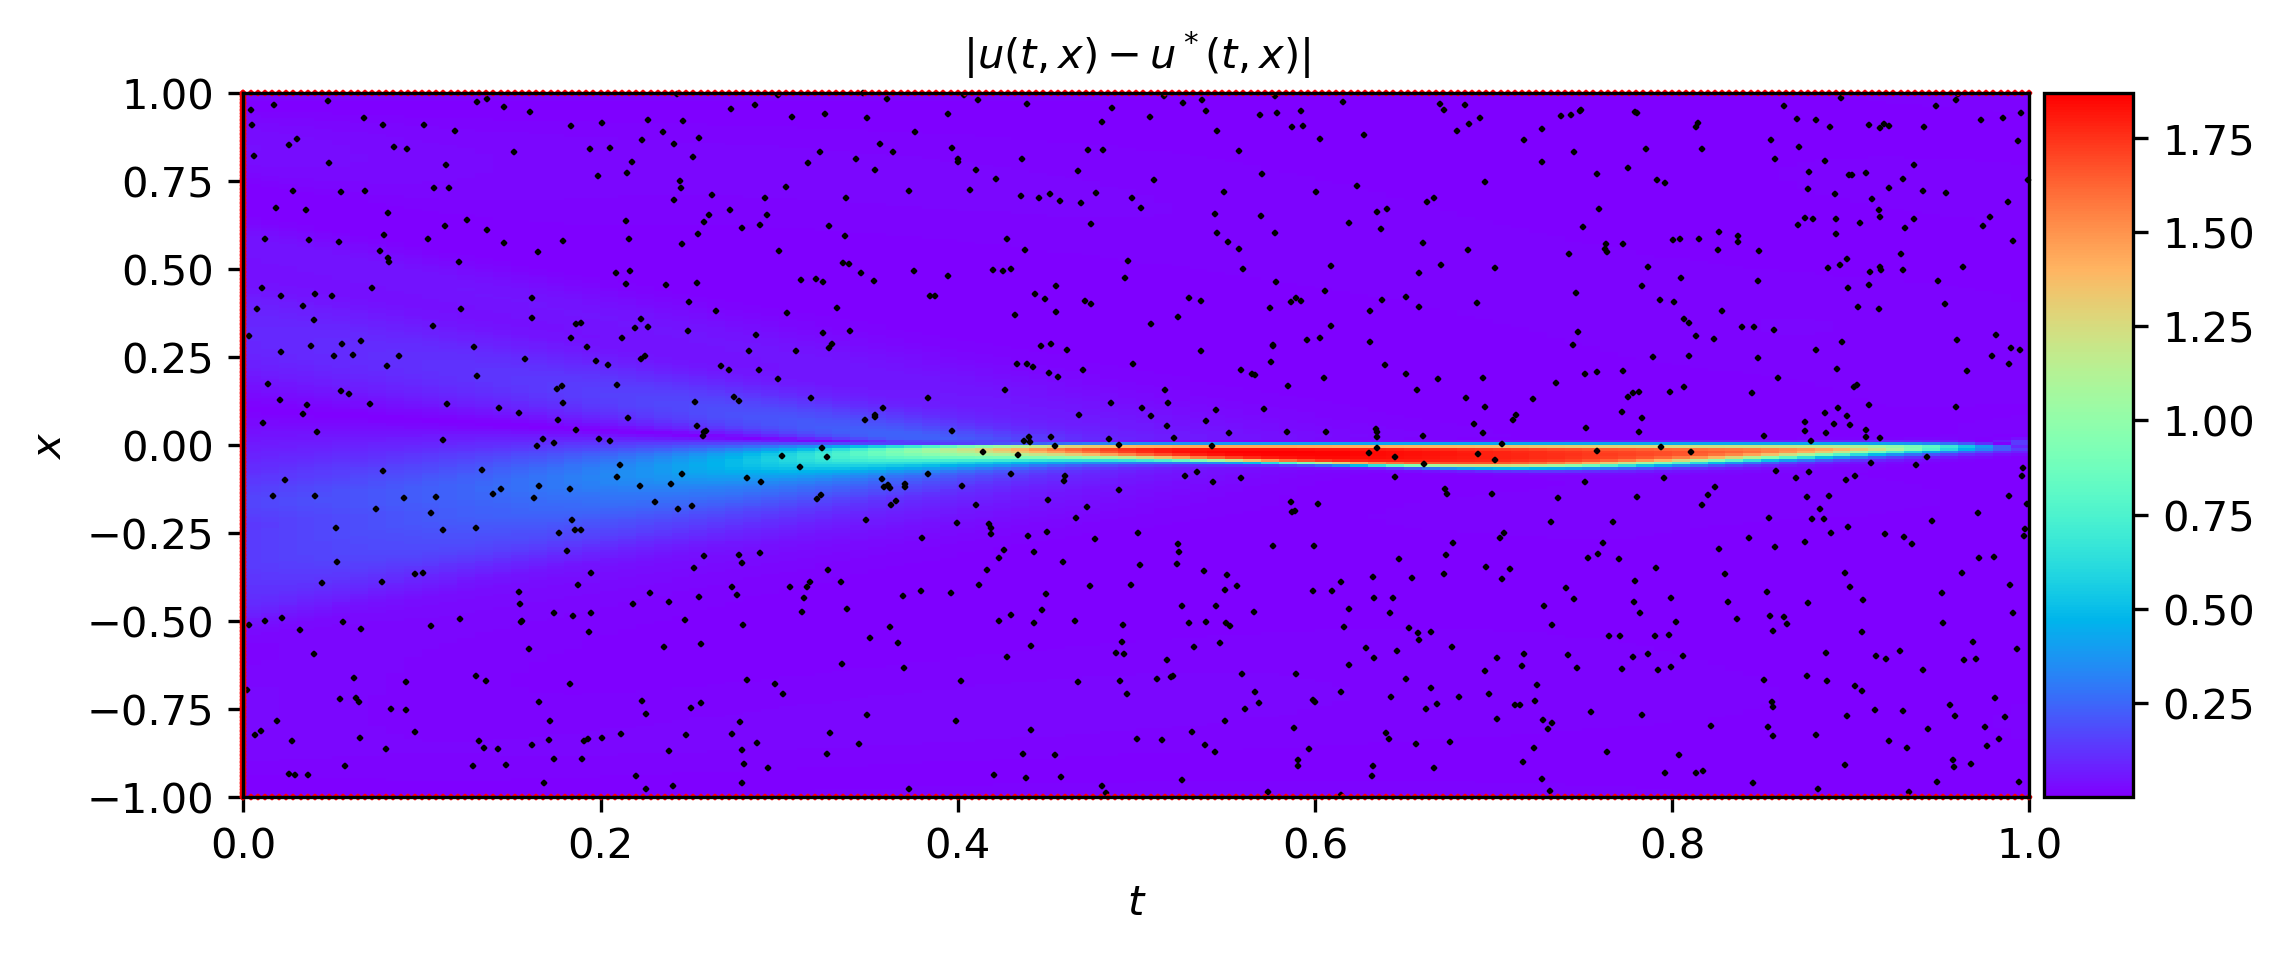

In [192]:
#absolute error
plt.figure(dpi=300,figsize=(9,11))
ax.axis('off')
pred=model(torch.tensor(X_exact).to(device)).cpu().detach().numpy()
U_pred = griddata(X_exact, pred.flatten(), (X, T), method='cubic')
U_star = griddata(X_exact, u_exact.flatten(), (X, T), method='cubic')
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])
U_diff= (abs(U_pred-U_star))
h = ax.imshow(U_diff.T, interpolation='nearest', cmap='rainbow', 
                  extent=[t.min(), t.max(), x.min(), x.max()], 
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('$|u(t,x)-u^*(t,x)|$', fontsize = 10)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax.plot(t_col.detach().cpu(),x_col.detach().cpu(), 'kx', label = 'Data (%d points)' % (u_star.shape[0]), markersize = 1, clip_on = False)
ax.plot(data_grid[:,1],data_grid[:,0], 'rx', label = 'Data (%d points)' % (u_star.shape[0]), markersize = 1, clip_on = False)
#plt.savefig('figs/u(t,x)diff_t.jpg',bbox_inches='tight',dpi=500)

In [193]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y
    def __len__(self):
        
        return len(self.data)

def loader(x,t,u,batch_size=None,train=True,augm_flag=True):
    if batch_size==None:
        batch_size=x.shape[0]
    dataset=MyDataset(data=torch.hstack([x[:,None],t[:,None]]).squeeze(),targets=u)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

In [194]:
n_epochs=10000

la = laplace.Laplace(model, 'regression', subset_of_weights='all', hessian_structure='full')
#la = laplace.Laplace(model, 'regression', subset_of_weights='last_layer', hessian_structure='full')
tloader=loader(x,t,u_star)
la.fit(tloader)
#
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [195]:
e=X_test=X_star
f_mu, f_var = la(torch.as_tensor(X_test).to(device).requires_grad_())
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

_LinAlgError: torch.linalg_cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 53 is not positive-definite).

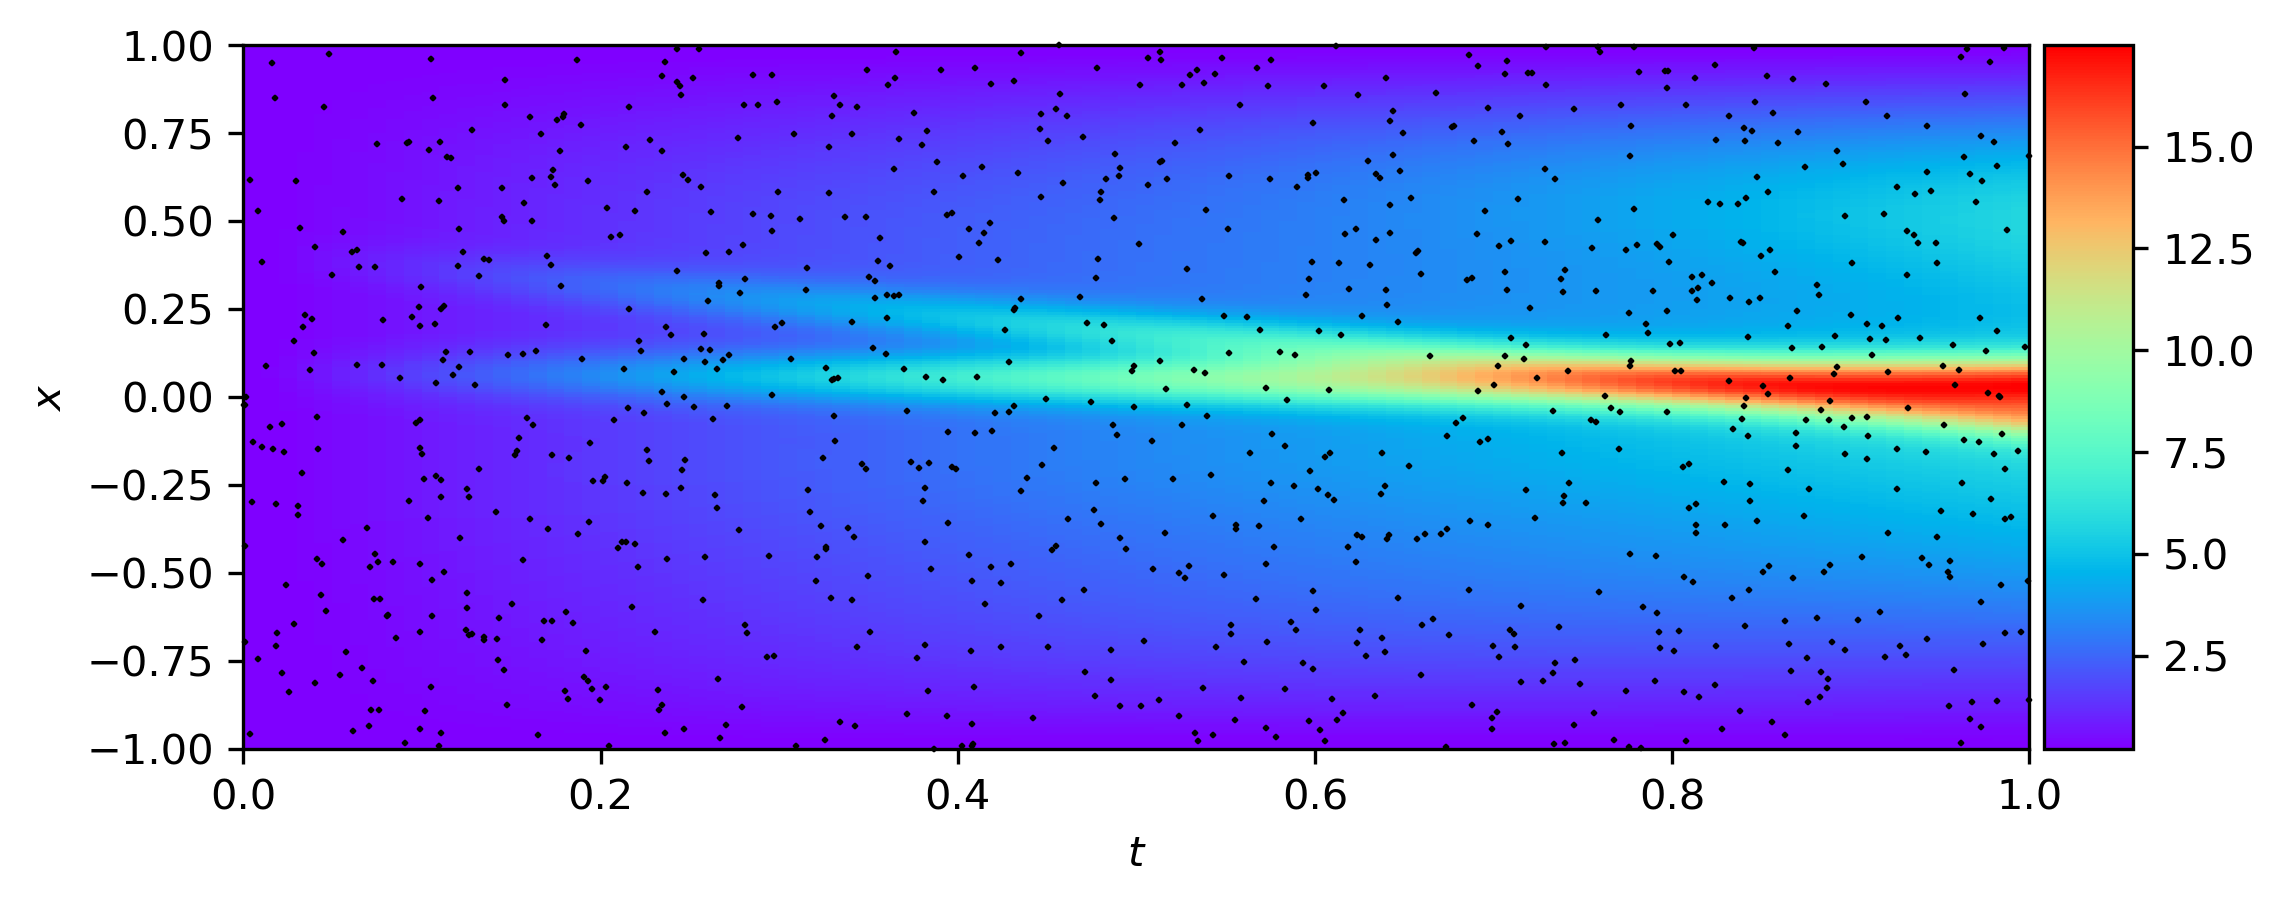

In [ ]:
#U_std
plt.figure(dpi=300,figsize=(9,11))
U_std = griddata(X_exact, pred_std.flatten(), (X, T), method='cubic')
U_mu = griddata(X_exact, f_mu.flatten(), (X, T), method='cubic')
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(abs((U_std)).T, interpolation='nearest', cmap='rainbow', extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax.plot(t_col.detach().cpu(),x_col.detach().cpu(), 'kx', label = 'Data (%d points)' % (u_star.shape[0]), markersize = 1, clip_on = False)

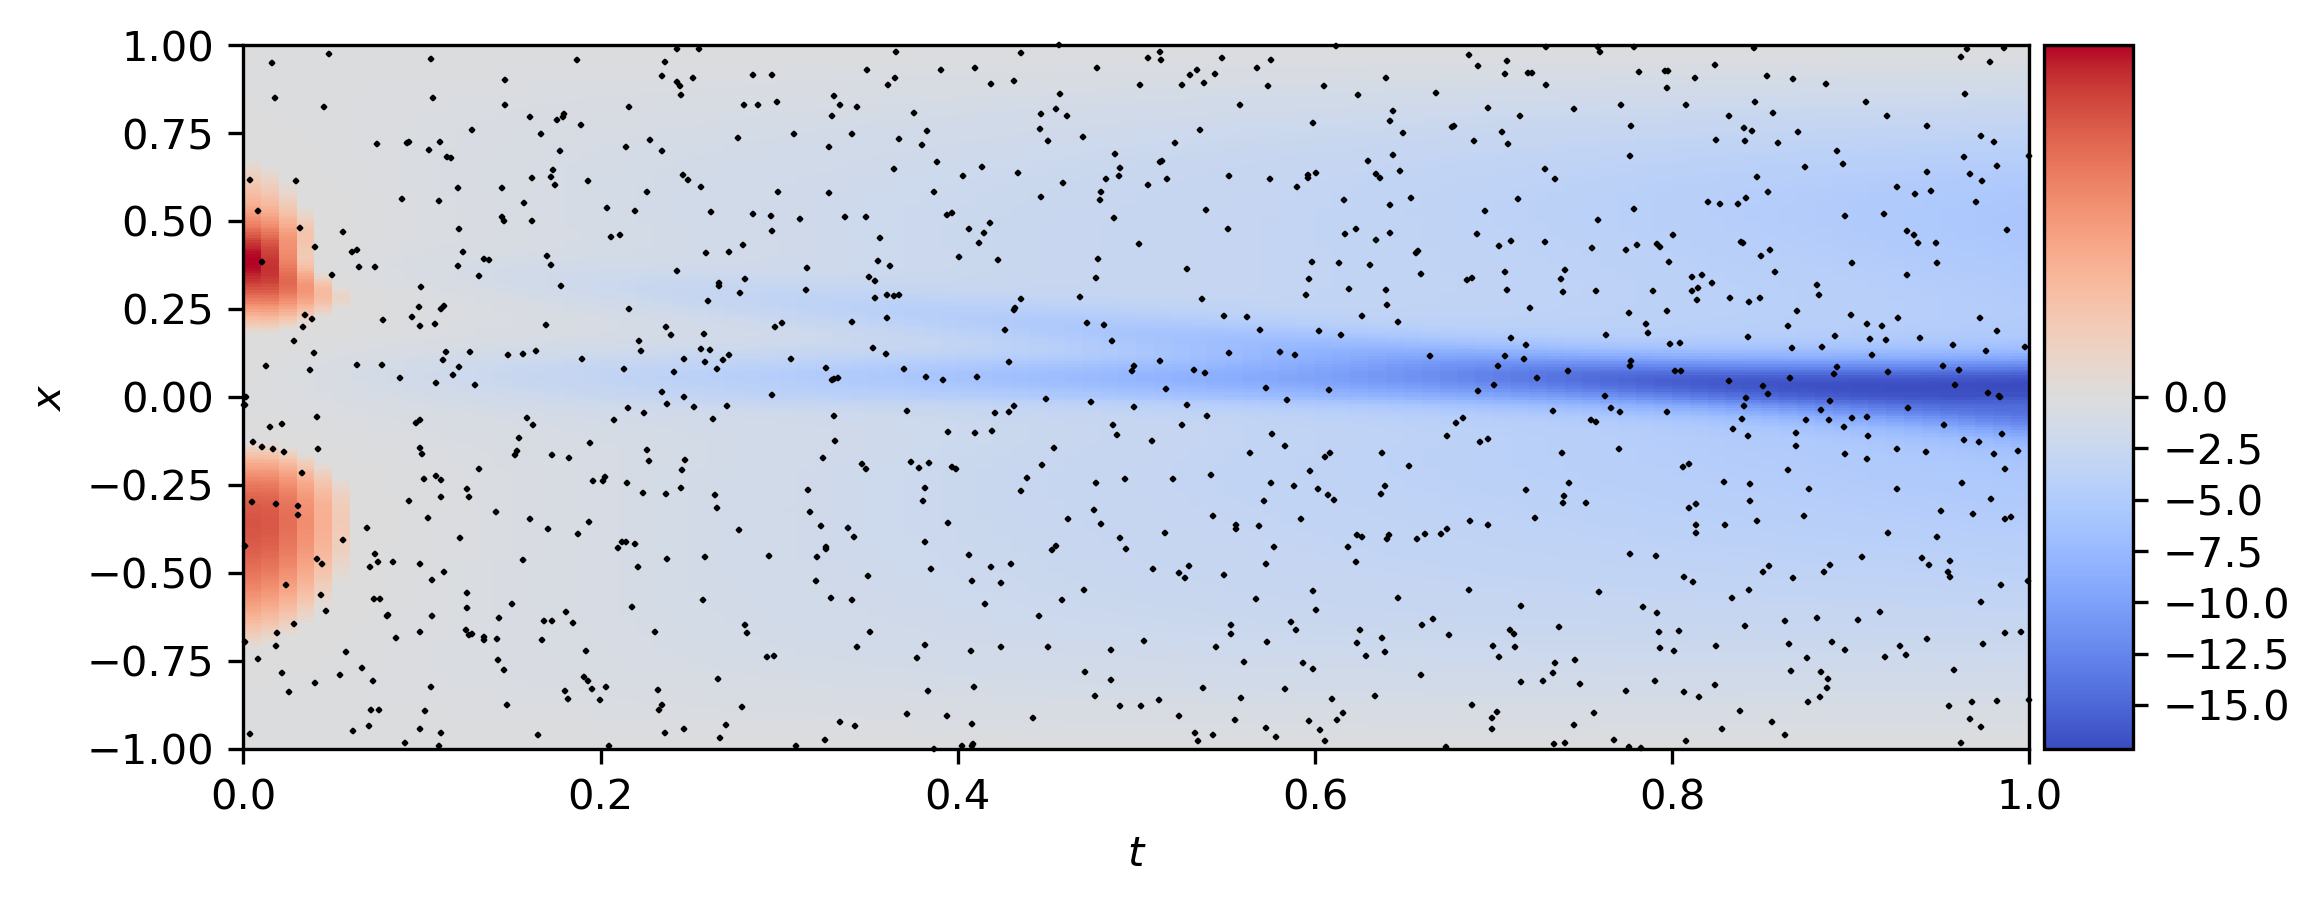

In [ ]:
#U_diff/U_std
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=(U_diff-abs(U_std)).min(), vcenter=0., vmax=(U_diff-abs(U_std)).max())

plt.figure(dpi=300,figsize=(9,11))
U_std = griddata(X_exact, pred_std.flatten(), (X, T), method='cubic')
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(((U_diff)-abs(U_std)).T, interpolation='nearest', cmap='coolwarm',norm=divnorm, extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax.plot(t_col.detach().cpu(),x_col.detach().cpu(), 'kx', label = 'Data (%d points)' % (u_star.shape[0]), markersize = 1, clip_on = False)

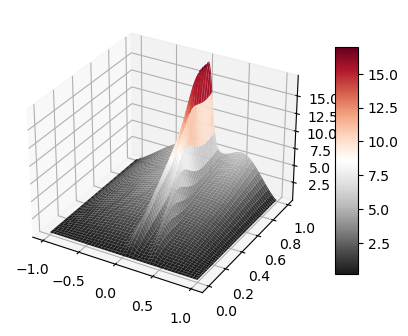

In [ ]:

fig = plt.figure(dpi=100)
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X,T,U_std, cmap=cm.RdGy_r)
fig.colorbar(surf, shrink=.75, aspect=10)
plt.show()